In [ ]:
from google.colab import drive
drive._mount('/content/drive', force_remount= True)

Mounted at /content/drive


In [ ]:
# Thêm thư viện
import numpy as np
from numpy import array
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import string
import os
from PIL import Image
import glob
from pickle import dump, load
from time import time

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                         Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization, GRU
from tensorflow.keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import Bidirectional
from keras.layers.merge import add
from keras.preprocessing import image
from keras.models import Model
from keras import Input, layers
from keras import optimizers
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.callbacks import History

from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction

# Load captions data






In [ ]:
# Đọc file các caption
def load_doc(filename):
	# open the file as read only
	file = open(filename, 'r')
	# read all text
	text = file.read()
	# close the file
	file.close()
	return text

filename = "/content/drive/MyDrive/Flickr8k/Flickr8k_text/Flickr8k.token.txt"

doc = load_doc(filename)
print(doc[:300])

1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg#1	A girl going into a wooden building .
1000268201_693b08cb0e.jpg#2	A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg#3	A little girl climbing the s


In [ ]:
# Lưu caption dưới dạng key value: id_image : ['caption 1', 'caption 2', 'caption 3',' caption 4', 'caption 5']
def load_descriptions(doc):
	mapping = dict()
	# process lines
	for line in doc.split('\n'):
		# split line by white space
		tokens = line.split()
		if len(line) < 2:
			continue
		# take the first token as the image id, the rest as the description
		image_id, image_desc = tokens[0], tokens[1:]
		# extract filename from image id
		image_id = image_id.split('.')[0]
		# convert description tokens back to string
		image_desc = ' '.join(image_desc)
		# create the list if needed
		if image_id not in mapping:
			mapping[image_id] = list()
		# store description
		mapping[image_id].append(image_desc)
	return mapping

descriptions = load_descriptions(doc)
# print('Loaded: %d ' % len(descriptions))

In [ ]:
# Lưu description xuống file
def save_descriptions(descriptions, filename):
	lines = list()
	for key, desc_list in descriptions.items():
		for desc in desc_list:
			lines.append(key + ' ' + desc)
	data = '\n'.join(lines)
	file = open(filename, 'w')
	file.write(data)
	file.close()

# save_descriptions(descriptions, 'drive/MyDrive/Flickr8k/descriptions.txt')

In [ ]:
# Descriptions loaders:
def descriptions_loader(token_file, descriptions_file):
  """
  ARGS:
    - token_file: path to token.txt
    - descriptions_file: file to save descriptions

  RETURNS:
    - descriptions: descriptions for images
  """
  # load data from token file
  doc = load_doc(token_file)

  # save captions as dict
  descriptions = load_descriptions(doc)

  save_descriptions(descriptions, descriptions_file)
  return descriptions

In [ ]:
token_file = "/content/drive/MyDrive/Flickr8k/Flickr8k_text/Flickr8k.token.txt"
descriptions_file = '/content/drive/MyDrive/Flickr8k/descriptions.txt'

descriptions = descriptions_loader(token_file, descriptions_file)

In [ ]:
descriptions['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

# Load images data

In [ ]:
# Lấy id ảnh tương ứng với dữ liệu train, test, dev
def load_set(filename):
	"""
		ARGS:
			- filename: path to image IDs file

		RETURNS:
			- dataset: set of image IDs
	"""
	doc = load_doc(filename)
	dataset = list()
	# process line by line
	for line in doc.split('\n'):
		# skip empty lines
		if len(line) < 1:
			continue
		# get the image identifier
		identifier = line.split('.')[0]
		dataset.append(identifier)
	return set(dataset)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

In [ ]:
# load training dataset (6K)
filename_train = '/content/drive/MyDrive/Flickr8k/Flickr8k_text/Flickr_8k.trainImages.txt'
train = load_set(filename_train)
# filename_val = '/content/drive/MyDrive/Flickr8k/Flickr8k_text/Flickr_8k.devImages.txt'
# validation = load_set(filename_val)

print('Dataset: %d' % len(train))
print(train)

Dataset: 6000
{'3098714492_19939e3b19', '241345446_2e47ae8ddc', '399212516_d68046b277', '2429978680_1e18a13835', '482907079_22085ada04', '2273038287_3004a72a34', '1160441615_fe6b3c5277', '3431121650_056db85987', '3174431688_ae84778db0', '2607099736_8681f601d9', '3582914905_f58db879ae', '2665264979_df9c284bf8', '2427490900_5b7a8874b9', '3654338683_13b2f95a9a', '3116379964_86986750af', '104136873_5b5d41be75', '3724759125_2dc0e1f4a3', '2916009941_34a0013803', '1798209205_77dbf525b0', '2866529477_7e0c053ebc', '3349194268_0ee555c9a2', '2439154641_bbf985aa57', '3640020134_367941f5ec', '707941195_4386109029', '2310233145_910cb5b4c8', '3549997413_01388dece0', '3442138291_3e75f4bdb8', '543102698_38e7e38bbc', '2964438493_413667c04a', '3524519277_bd0c3e7382', '3230132205_dccfafa5ee', '3396036947_0af6c3aab7', '263233914_d25004e4cd', '385186343_464f5fc186', '3703960010_1e4c922a25', '3224578187_749882c17f', '3700346840_bb80d622f7', '3368819708_0bfa0808f8', '3197247245_9c93b60b8a', '3236677456_75821e

In [ ]:
# Thêm 'startseq', 'endseq' cho chuỗi
def load_clean_descriptions(filename, dataset):
	# load document
	doc = load_doc(filename)
	descriptions = dict()
	for line in doc.split('\n'):
		# split line by white space
		tokens = line.split()
		# split id from description
		image_id, image_desc = tokens[0], tokens[1:]
		# skip images not in the set
		if image_id in dataset:
			# create list
			if image_id not in descriptions:
				descriptions[image_id] = list()
			# wrap description in tokens
			desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
			# store
			descriptions[image_id].append(desc)
	return descriptions

# descriptions
train_descriptions = load_clean_descriptions('/content/drive/MyDrive/Flickr8k/descriptions.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))
# validation_descriptions = load_clean_descriptions('/content/drive/MyDrive/Flickr8k/descriptions.txt', validation)
# print('Descriptions: train=%d' % len(validation_descriptions))


Descriptions: train=6000


In [ ]:
# Tạo list các training caption
all_train_captions = []
for key, val in train_descriptions.items():
    for cap in val:
        all_train_captions.append(cap)
len(all_train_captions)

30000

In [ ]:
# Chỉ lấy các từ xuất hiện trên 10 lần
word_count_threshold = 10
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1

vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
print('preprocessed words %d -> %d' % (len(word_counts), len(vocab)))

preprocessed words 8256 -> 1698


In [ ]:
ixtoword = {}
wordtoix = {}

ix = 1
for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1

In [ ]:
vocab_size = len(ixtoword) + 1 # Thêm 1 cho từ dùng để padding
vocab_size

1699

In [ ]:
# convert a dictionary of clean descriptions to a list of descriptions
def to_lines(descriptions):
	all_desc = list()
	for key in descriptions.keys():
		[all_desc.append(d) for d in descriptions[key]]
	return all_desc

# calculate the length of the description with the most words
def max_length(descriptions):
	lines = to_lines(descriptions)
	return max(len(d.split()) for d in lines)

# determine the maximum sequence length
max_length = max_length(train_descriptions)
print('Description Length: %d' % max_length)

Description Length: 40


In [ ]:
# Load Glove model
glove_dir = '/content/drive/MyDrive/ImageCaptioning/Glove'
embeddings_index = {} # empty dictionary
f = open(os.path.join(glove_dir, 'glove.6B.200d.txt'), encoding="utf-8")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [ ]:
embedding_dim = 200

# Get 200-dim dense vector for each of the 10000 words in out vocabulary
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in wordtoix.items():
    #if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector

In [ ]:
embedding_matrix.shape

(1699, 200)

#Callbacks


In [ ]:
from keras.callbacks import LearningRateScheduler, ModelCheckpoint, ReduceLROnPlateau
import tensorflow as tf
import time

def call_backs(state_model):
    def scheduler(epoch, lr):
        # Nếu dưới 12 epoch
        if epoch < 2:
            # Trả về lr
            return float(lr)
        else:
            # Còn không thì trả về
            return float(lr * tf.math.exp(-0.1))
    lrsc = LearningRateScheduler(scheduler)

    rlrop = ReduceLROnPlateau(monitor = 'train_loss',
                            patience = 2,
                            mode='auto',
                            factor = 0.3,
                            min_lr = 1e-9,
                            verbose = 1)

    filepath_callbacks = '/content/drive/MyDrive/ImageCaptioning/model_weights/' + state_model + \
                         '/weight_EB0_biLSTM_' + time.strftime("%d-%m-%Y-%H:%M:%S", time.localtime()) +'.h5'
    mdcp = ModelCheckpoint(filepath_callbacks,
                            monitor="loss",
                            save_best_only=True,
                            verbose=1)

    if state_model == 'warmup':
        # return [rlrop, mdcp]
        return [lrsc, mdcp]

    return [lrsc, mdcp]

# Warm-up LSTM Layer


In [ ]:
# data generator cho việc train theo từng batch model.fit_generator()
def data_generator_warmUp(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            # retrieve the photo feature
            photo = photos[key+'.jpg']
            for desc in desc_list:
                # encode the sequence
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
            # yield the batch data
            if n==num_photos_per_batch:
                yield ([array(X1), array(X2)], array(y))
                X1, X2, y = list(), list(), list()
                n=0

In [ ]:
train_features = load(open("/content/drive/MyDrive/ImageCaptioning/blur_image/encoded_blur_train_images.pkl", "rb"))
print('Photos: train=%d' % len(train_features))
validation_features = load(open("/content/drive/MyDrive/Flickr8k/EfficientNetB0/encoded_validation_images.pkl", "rb"))
print('Photos: validation=%d' % len(validation_features))

Photos: train=61
Photos: validation=1000


In [ ]:
print(list(validation_features.values())[0].shape)

NameError: ignored

In [ ]:
from tensorflow.keras.applications import EfficientNetB0
# Load the efficient net
model = EfficientNetB0(weights='imagenet')
Embedding_CV_Layer = Model(model.input, model.layers[-2].output)
# size of efficentNet
in_size_CV = model.input.shape[1]
out_size_CV = model.layers[-2].output.shape[1]

In [ ]:
# Build NLP embedding layer
Embedding_NLP_Layer = Embedding(vocab_size, embedding_dim, mask_zero=True)
input_NLP_layer = Input(shape=(max_length,))
output_NLP_layer = Embedding_NLP_Layer(input_NLP_layer)
Embedding_NLP_Layer = Model(input_NLP_layer, output_NLP_layer)
# Embedding_NLP_Layer.set_weights([embedding_matrix])
Embedding_NLP_Layer.layers[1].set_weights([embedding_matrix])
Embedding_NLP_Layer.layers[1].trainable = False
Embedding_NLP_Layer.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 40)]              0         
                                                                 
 embedding (Embedding)       (None, 40, 200)           339800    
                                                                 
Total params: 339,800
Trainable params: 0
Non-trainable params: 339,800
_________________________________________________________________


In [ ]:
# Tạo model
class CV_warmup_layer(layers.Layer):
    def __init__(self):
        super(CV_warmup_layer, self).__init__()
        self.ff1 = Dense(1024, activation='relu')
        self.dropout = Dropout(0.3)
        self.ffout = Dense(512, activation='relu')
    def call(self, inputs):
        x = self.dropout(inputs)
        x = self.ff1(x)
        x = self.dropout(x)
        x = self.ffout(x)
        return x
# Layer CV
cv_warmup_layer = CV_warmup_layer()
# inputCV = Input(shape=(1792,))
# output_CV = cv_warmup_layer(inputCV)
# cv_warmup_layer = Model(inputCV, output_CV)

class NLP_layer(layers.Layer):
    def __init__(self):
        super(NLP_layer, self).__init__()
        self.droput = Dropout(0.5)
        self.LSTM = Bidirectional(GRU(256))
        # self.embed_layer = Embedding(vocab_size, embedding_dim, mask_zero=True).set_weights([embedding_matrix])
        self.embed_layer = Embedding_NLP_Layer
    def call(self, inputs):
        se1 = self.embed_layer(inputs)
        se2 = self.droput(se1)
        se3 = self.LSTM(se2)
        # print(se3)
        return se3
# Layer NLP
nlp_warmup_layer = NLP_layer()
# inputNLP = Input(shape=(max_length,))
# output_NLP = nlp_warmup_layer(inputNLP)
# nlp_warmup_layer = Model(inputNLP, output_NLP)

class Head(layers.Layer):
    def __init__(self):
        super(Head, self).__init__()
        self.ff1 = Dense(512, activation='relu')
        self.dropout = Dropout(0.3)
        self.ff2 = Dense(256, activation='relu')
        self.ffout = Dense(vocab_size, activation='softmax')
    def call(self, output_CV_NLP):
        decoder1 = add(output_CV_NLP)
        decoder2 = self.ff1(decoder1)
        decoder3 = self.dropout(decoder2)
        decoder4 = self.ff2(decoder3)
        outputs = self.ffout(decoder4)
        return outputs
# Layer Head
head = Head()
# inputCVHead = Input(shape=(512,))
# inputNLPHead = Input(shape=(512,))
# output_Head = head([inputCVHead, inputNLPHead])
# head = Model(inputs= [inputCVHead, inputNLPHead], outputs= output_Head)

class ICModel():
    def __init__(self, out_size_CV, use_embCV = False, input_size= False):
        self.cv_layer = cv_warmup_layer 
        self.out_size_CV = out_size_CV
        self.nlp_layer = nlp_warmup_layer
        self.head = head
        self.use_embCV = use_embCV
        
        if use_embCV:
            self.embed_layer = Embedding_CV_Layer
            self.input_size = input_size
    def build_warmUpModel(self):
        if self.use_embCV:
            inputs1 = Input(shape=(self.input_size, self.input_size, 3))
            x = self.embed_layer(inputs1)
            x = Reshape((self.out_size_CV,))(x)
            output_CV = self.cv_layer(x)
        else:
            inputs1 = Input(shape=(self.out_size_CV,))
            output_CV = self.cv_layer(inputs1)

        inputs2 = Input(shape=(max_length,))
        output_NLP = self.nlp_layer(inputs2)

        outputs = self.head([output_CV, output_NLP])

        warmUpModel = Model(inputs=[inputs1, inputs2], outputs=outputs)
        return warmUpModel

#Bỏ qua cục này


In [ ]:
# Model
warmUpModel = ICModel(out_size_CV)
weights_finetune = os.listdir(weight_dir) 
weights_warmup = os.listdir(os.path.join(weight_dir, 'warmup'))
warmUpModel = warmUpModel.build_warmUpModel()
if len(weights_warmup):
    print(weights_warmup)   
    warmUpModel.load_weights(os.path.join(weight_dir, 'warmup',weights_warmup[0]))
warmUpModel.summary()

['weight_EB0_biLSTM_21-12-2021-01:17:52.h5']
Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 1280)]       0           []                               
                                                                                                  
 input_12 (InputLayer)          [(None, 40)]         0           []                               
                                                                                                  
 cv_warmup_layer (CV_warmup_lay  (None, 512)         1836544     ['input_11[0][0]']               
 er)                                                                                              
                                                                                                  
 nlp_layer (NLP_layer)          (None, 512)    

In [ ]:
warmUpModel.compile(loss='categorical_crossentropy', optimizer='adam')
warmUpModel.optimizer.lr = 0.001
wamrUp_number_pics_per_bath = 120
warmUp_steps = len(train_descriptions)//wamrUp_number_pics_per_bath

In [ ]:
# print('TRAIN: ')
warmUp_train_generator = data_generator_warmUp(train_descriptions, train_features, wordtoix, max_length, wamrUp_number_pics_per_bath)
# print('VALID: ')
# warmUp_validation_generator = data_generator_warmUp(validation_descriptions, validation_features, wordtoix, max_length, wamrUp_number_pics_per_bath)

In [ ]:
warmUp_history = warmUpModel.fit_generator(warmUp_train_generator, epochs=15, \
                                           steps_per_epoch=warmUp_steps, verbose=1, \
                                           callbacks=call_backs('warmup'))
                                        #    validation_data=warmUp_validation_generator)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """Entry point for launching an IPython kernel.


Epoch 1/15
50/50 [==============================] - ETA: 0s - loss: 5.0850
Epoch 00001: loss improved from inf to 5.08502, saving model to /content/drive/MyDrive/ImageCaptioning/model_weights/warmup/weight_EB0_biLSTM_21-12-2021-01:17:52.h5
50/50 [==============================] - 83s 1s/step - loss: 5.0850 - lr: 0.0010
Epoch 2/15
50/50 [==============================] - ETA: 0s - loss: 3.9686
Epoch 00002: loss improved from 5.08502 to 3.96858, saving model to /content/drive/MyDrive/ImageCaptioning/model_weights/warmup/weight_EB0_biLSTM_21-12-2021-01:17:52.h5
50/50 [==============================] - 74s 1s/step - loss: 3.9686 - lr: 0.0010
Epoch 3/15
50/50 [==============================] - ETA: 0s - loss: 3.5391
Epoch 00003: loss improved from 3.96858 to 3.53913, saving model to /content/drive/MyDrive/ImageCaptioning/model_weights/warmup/weight_EB0_biLSTM_21-12-2021-01:17:52.h5
50/50 [==============================] - 74s 1s/step - loss: 3.5391 - lr: 9.0484e-04
Epoch 4/15
50/50 [=======

#Tiếp tục từ đây

#Train Embedding Image Layer


In [ ]:
# data generator cho việc train theo từng batch model.fit_generator()
def data_generator_finetune(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            # retrieve the photo feature
            photo = photos[key+'.jpg']
            for desc in desc_list:
                # encode the sequence
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append(photo.reshape((in_size_CV,in_size_CV,3)))
                    X2.append(in_seq)
                    y.append(out_seq)
            # yield the batch data
            if n==num_photos_per_batch:
                yield ([array(X1), array(X2)], array(y))
                X1, X2, y = list(), list(), list()
                n=0

In [ ]:
train_features_finetune = load(open("/content/drive/MyDrive/Flickr8k/EfficientNetB0/pre_train_images.pkl", "rb"))
# validation_features_finetune = load(open("/content/drive/MyDrive/Flickr8k/EfficientNetB0/pre_validation_images.pkl", "rb"))
# print('Photos: train=%d' % len(train_features_finetune))

In [ ]:
# Model
import os
weight_dir = '/content/drive/MyDrive/Colab Notebooks/CV'
FinetuneModel = ICModel(out_size_CV, use_embCV=True, input_size=in_size_CV)
FinetuneModel = FinetuneModel.build_warmUpModel()
weights_finetune = os.listdir(weight_dir) 
# FinetuneModel = FinetuneModel.build_warmUpModel()
if len(weights_finetune):
    FinetuneModel.load_weights(os.path.join(weight_dir,weights_finetune[-1]))
    print(weight_dir,weights_finetune[-1])
FinetuneModel.summary()

/content/drive/MyDrive/Colab Notebooks/CV weight_EB0_biLSTM_22-12-2021-03_02_02.h5
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 model (Functional)             (None, 1280)         4049571     ['input_3[0][0]']                
                                                                                                  
 reshape (Reshape)              (None, 1280)         0           ['model[0][0]']                  
                                                                                                  
 input_4 

In [ ]:
FinetuneModel.compile(loss='categorical_crossentropy', optimizer='adam')
FinetuneModel.optimizer.lr = 0.001
Finetune_number_pics_per_bath = 1
Finetune_steps = len(train_descriptions)//Finetune_number_pics_per_bath

In [ ]:
train_finetune_generator = data_generator_finetune(train_descriptions, train_features_finetune, wordtoix, max_length, Finetune_number_pics_per_bath)
# val_finetune_generator = data_generator_finetune(validation_descriptions, validation_features_finetune, wordtoix, max_length, Finetune_number_pics_per_bath)
 
FinetuneHistory = FinetuneModel.fit_generator(train_finetune_generator, epochs=2, verbose=1, \
                                              callbacks=call_backs('finetune'), steps_per_epoch=Finetune_steps)
                                            #   validation_data=val_finetune_generator)
    # # Tính BLEU trên bộ val
    # calculateBLEU(val, model)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  after removing the cwd from sys.path.


Epoch 1/2
6000/6000 [==============================] - ETA: 0s - loss: 3.1300
Epoch 00001: loss improved from inf to 3.12999, saving model to /content/drive/MyDrive/ImageCaptioning/model_weights/finetune/weight_EB0_biLSTM_22-12-2021-03:02:02.h5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


6000/6000 [==============================] - 7495s 1s/step - loss: 3.1300 - lr: 0.0010
Epoch 2/2
6000/6000 [==============================] - ETA: 0s - loss: 3.0754
Epoch 00002: loss improved from 3.12999 to 3.07544, saving model to /content/drive/MyDrive/ImageCaptioning/model_weights/finetune/weight_EB0_biLSTM_22-12-2021-03:02:02.h5
6000/6000 [==============================] - 7552s 1s/step - loss: 3.0754 - lr: 0.0010


In [ ]:
print(history.history)

In [ ]:
model.save_weights('drive/MyDrive/ImageCaptioning/model_weights/bsl_e20_b60.h5')

In [ ]:
# Đồ thị giảm của hàm loss
losses = history.history["loss"]
epoches = [i+1 for i in range(len(losses))]
print(epoches)

plt.plot(epoches, losses)
plt.xlabel("Epoches")
plt.ylabel("Losses")

plt.show()


In [ ]:
# model.load_weights('drive/MyDrive/ImageCaptioning/model_weights/bsl_e20_b12.h5')

# Evaluation

In [ ]:
# Với môi ảnh mới khi test, ta sẽ bắt đầu chuỗi với 'startseq' rồi sau đó cho vào model để dự đoán từ tiếp theo. Ta thêm từ
# vừa được dự đoán vào chuỗi và tiếp tục cho đến khi gặp 'endseq' là kết thúc hoặc cho đến khi chuỗi dài max_length từ.
def greedySearch(photo, model):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

In [ ]:
images = '/content/drive/MyDrive/Flickr8k/Flickr8k_Dataset/Flicker8k_Dataset/'

In [ ]:
with open("/content/drive/MyDrive/Flickr8k/EfficientNetB0/pre_test_images.pkl", "rb") as encoded_pickle:
    encoding_test = load(encoded_pickle)

2894217628_f1a4153dca.jpg
A man in a red shirt is standing on a rock face .


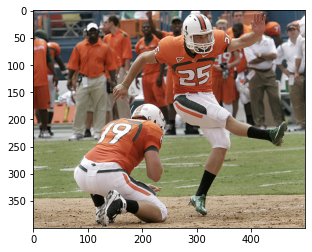

In [ ]:
z=13
pic = list(encoding_test.keys())[z]
print(pic)

image = encoding_test[pic]
print(greedySearch(image, FinetuneModel))
x = plt.imread(images+pic)
plt.imshow(x)
plt.show()

In [ ]:
from tqdm import tqdm

In [ ]:
def calculateBLEU(encoding_set, model):
  '''
    ARGS:
      - encoding_set: feature vectors của tập dữ liệu cần đánh giá BLEU Score
      - model: model Image Captioning tương ứng
    RETURNS:
      - avg_bleu_score: BLEU Score trung bình cho toàn bộ tập dữ liệu
  '''
  data_size = len(encoding_set)
  accumulated_score = 0
  predictions = {}
  for z in tqdm(range(data_size), total=data_size):
    sample = list(encoding_set.keys())[z]
    # Loading descriptions from groundtruth
    references = descriptions[sample[:-4]]
    references = [ref.split(" ")[:-1] for ref in references]

    # Getting model's prediction
    embedding = encoding_set[sample]
    prediction = greedySearch(embedding, model)
    predictions[sample[:-4]] = prediction
    prediction = prediction.split(" ")[:-1]

    # Calculating each sample's BLEU
    bleu_score = sentence_bleu(references, prediction)
    accumulated_score += bleu_score

  avg_bleu_score = accumulated_score / data_size
  print(f"BLEU Score: {avg_bleu_score}")
  return avg_bleu_score

In [ ]:
calculateBLEU(encoding_test, FinetuneModel)

  0%|          | 0/1000 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
  0%|          | 3/1000 [00:03<20:10,  1.21s/it]/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
  0%|          | 4/1000 [00:04<19:57,  1.20s/it]/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
100%|██████████| 1000/1000 [20:12<00:00,  1.21s/it]

BLEU Score: 0.5102382662986735


0.5102382662986735

In [ ]:
with open("/content/drive/MyDrive/Flickr8k/EfficientNetB0/encoded_test_images.pkl", "rb") as encoded_pickle:
    encoding_test_warmup = load(encoded_pickle)

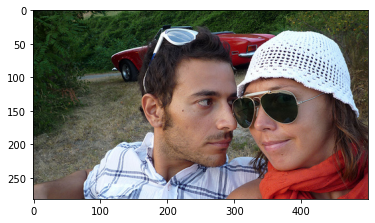

A man in a red shirt and a black hat and a black hat and a black hat .


In [ ]:
z=11
pic = list(encoding_test_warmup.keys())[z]

image = encoding_test_warmup[pic].reshape((1,1280))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print(greedySearch(image, warmUpModel))

In [ ]:
def calculateBLEU_warmup(encoding_set, model):
  '''
    ARGS:
      - encoding_set: feature vectors của tập dữ liệu cần đánh giá BLEU Score
      - model: model Image Captioning tương ứng
    RETURNS:
      - avg_bleu_score: BLEU Score trung bình cho toàn bộ tập dữ liệu
  '''
  data_size = len(encoding_set)
  accumulated_score = 0
  predictions = {}
  for z in tqdm(range(data_size), total=data_size):
    sample = list(encoding_set.keys())[z]
    # Loading descriptions from groundtruth
    references = descriptions[sample[:-4]]
    references = [ref.split(" ")[:-1] for ref in references]

    # Getting model's prediction
    embedding = encoding_set[sample].reshape((1,1280))
    prediction = greedySearch(embedding, model)
    predictions[sample[:-4]] = prediction
    prediction = prediction.split(" ")[:-1]

    # Calculating each sample's BLEU
    bleu_score = sentence_bleu(references, prediction)
    accumulated_score += bleu_score

  avg_bleu_score = accumulated_score / data_size
  print(f"BLEU Score: {avg_bleu_score}")
  return avg_bleu_score

In [ ]:
calculateBLEU_warmup(encoding_test_warmup, warmUpModel)

  0%|          | 2/1000 [00:01<12:16,  1.35it/s]/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
  0%|          | 4/1000 [00:03<12:46,  1.30it/s]/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
  0%|          | 5/1000 [00:03<12:38,  1.31it/s]/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
100%|██████████| 1000/1000 [15:22<00:00,  1.08it/s]

BLEU Score: 0.5013069462417498


0.5013069462417498

In [ ]:
from google.colab.patches import cv2_imshow
import cv2
from keras.preprocessing import image
custom_pic ="drive/MyDrive/ImageCaptioning/girl.jpeg"
embedding = encode(custom_pic, image_embeddings).reshape((1,2048))
img = cv2.imread(custom_pic)
cv2_imshow(img)
print(greedySearch(embedding, model))

In [ ]:
# def build_finetune_model(warmUp_model):
#     inputs1 = Input(shape=(380, 380, 3))
#     x = EmbeddingLayer(inputs1)
#     x = Reshape((1792,))(x)
#     fe1 = Dropout(0.5)(x)
#     fe2 = Dense(256, activation='relu')(fe1)
#     inputs2 = Input(shape=(max_length,))
#     se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
#     se2 = Dropout(0.5)(se1)
#     se3 = LSTM(256)(se2)  # tinh chỉnh LSTM/ Bi-LSTM/ GRU (Hiếu)
#     decoder1 = add([fe2, se3])
#     decoder2 = Dense(256, activation='relu')(decoder1)
#     outputs = Dense(vocab_size, activation='softmax')(decoder2)
#     model = Model(inputs=[inputs1, inputs2], outputs=outputs)
#     return model